In [5]:
import os 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [6]:
EXPECTED_RESULTS_DIR = './expected'
RESULTS_DIR = './results'
SAMPLES_DIR = './Samples'
SUB_DIRS =['cmds','defs','exprs','prim','stat']

# 1. Lancer les résultats

In [23]:
import platform, subprocess
def type(file_path:str,result_path:str): 
    type_cmds = [f"./type.sh",file_path]
    try : 
        if platform.system() == "Windows":
            type_cmds = ['wsl']+type_cmds
        resultat = subprocess.run(type_cmds, shell=True, capture_output=True, text=True, check=True)
        sortie = resultat.stdout
        type_result = (sortie.rstrip()).split('\n')
    except subprocess.CalledProcessError as e:
        type_result=(str(e.output).rstrip()).split('\n')
    with open(result_path,'w') as f : 
        f.write('\n'.join(type_result))
def eval(file_path:str,result_path:str): 
    eval_cmds = [f"./eval",file_path]
    try : 
        if platform.system() == "Windows":
            eval_cmds = ['wsl']+eval_cmds
        resultat = subprocess.run(eval_cmds, shell=True, capture_output=True, text=True, check=True)
        sortie = resultat.stdout
        eval_result = (sortie.rstrip()).split('\n')
    except subprocess.CalledProcessError as e:
        eval_result=[e.stderr]
    with open(result_path,'w') as f : 
        f.writelines('\n'.join(eval_result))
    
    
def run_typing_and_eval(file_path:str,result_dir:str):
    type(file_path,result_dir+'/type.result')
    eval(file_path,result_dir+'/eval.result')
 

In [24]:
for dir in SUB_DIRS: 
    if not os.path.exists(f'{RESULTS_DIR}/{dir}'):
        os.makedirs(f'{RESULTS_DIR}/{dir}')
    for file in os.listdir(f'{SAMPLES_DIR}/{dir}') : 
        file_name = file.split('.')[0]
        file_path = f'{SAMPLES_DIR}/{dir}/{file}'
        result_dir = f'{RESULTS_DIR}/{dir}/{file_name}'
        if not os.path.exists(result_dir):
            os.makedirs(result_dir)
        run_typing_and_eval(file_path,result_dir)
        

# 2. Vérifier les résultats

In [25]:
COLUMNS=['file_name','type','eval','correctly_type','correctly_eval']

In [26]:
def initialise_results(columns):
    df = pd.DataFrame(columns=columns)
    if not os.path.exists('./results'):
        os.makedirs('./results')
    df.to_csv(f'./results/results.csv',index=False)
    return df

In [27]:
def save_results(df,results:list,columns:list):
    df = pd.DataFrame([results],columns=columns) 
    df.to_csv(f'./results/results.csv',mode='a',index=False,header=False)

In [28]:
def validate(expected_file_path:str,result_file_path:str): 
    with open(expected_file_path,'r') as f : 
        expected= f.read().splitlines() 
    with open(result_file_path,'r') as f : 
        results= f.read().splitlines() 
    if len(expected)!=len(results) : 
        return False 
    for e,r in zip(expected,results) : 
        if e!=r : 
            return False 
    return True

def is_correctly_typed(result_file_path:str) : 
    with open(result_file_path,'r') as f : 
        result= f.read().splitlines()
    return result[0]=='void'  

def is_correctly_eval(result_file_path:str) : 
    with open(result_file_path,'r') as f : 
        result= f.read().splitlines()
    return result[-1]=='eval'  

In [29]:
df = initialise_results(COLUMNS)
for dir in SUB_DIRS : 
    for file in os.listdir(f'{SAMPLES_DIR}/{dir}') :
        file_name = file.split('.')[0]
        expected_dir = f'{EXPECTED_RESULTS_DIR}/{dir}/{file_name}'
        result_dir = f'{RESULTS_DIR}/{dir}/{file_name}'
        # Type 
        type_result = validate(f'{expected_dir}/type.result',f'{result_dir}/type.result')
        eval_result = validate(f'{expected_dir}/eval.result',f'{result_dir}/eval.result')
        correctly_typed = is_correctly_typed(f'{result_dir}/type.result')
        correctly_eval = is_correctly_eval(f'{result_dir}/eval.result')
        results=[file_name,type_result,eval_result,correctly_typed,correctly_eval]
        save_results(df,results,COLUMNS)
        
        pass 

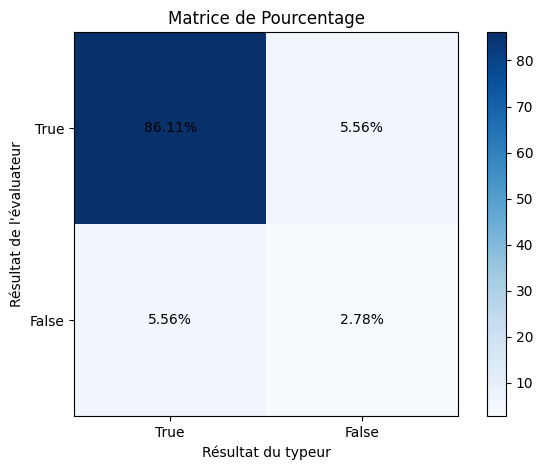

In [30]:
df = pd.read_csv('./results/results.csv')
# Convertir les colonnes 'type' et 'eval' en type booléen
df['correctly_type'] = df['correctly_type'].astype(bool)
df['correctly_eval'] = df['correctly_eval'].astype(bool)

# Calculer les pourcentages
total_count = len(df)
true_true_count = ((df['correctly_type'] == True) & (df['correctly_eval'] == True)).sum()
true_false_count = ((df['correctly_type'] == True) & (df['correctly_eval'] == False)).sum()
false_true_count = ((df['correctly_type'] == False) & (df['correctly_eval'] == True)).sum()
false_false_count = ((df['correctly_type'] == False) & (df['correctly_eval'] == False)).sum()

true_true_percentage = (true_true_count / total_count) * 100
true_false_percentage = (true_false_count / total_count) * 100
false_true_percentage = (false_true_count / total_count) * 100
false_false_percentage = (false_false_count / total_count) * 100

# Créer la matrice carrée des pourcentages
conf_matrix = [[true_true_percentage, false_true_percentage],
               [true_false_percentage, false_false_percentage]]

# Afficher la matrice carrée
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de Pourcentage')
plt.colorbar()

classes = ['True', 'False']
tick_marks = [0, 1]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{conf_matrix[i][j]:.2f}%", horizontalalignment='center', verticalalignment='center')

plt.ylabel('Résultat de l\'évaluateur')
plt.xlabel('Résultat du typeur')
plt.tight_layout()
plt.show()